# Maptember (Mapvember?) 2023
Most of the time it feels like I'm whispering into a void on social media these days, so this, dear mapmakers, is now a selfish exercise. As usual, many thanks for Topi [for putting this challenge together](https://30daymapchallenge.com/)

This year will be a.) a late start, and b.) a beginner-brain attempt to create all the maps in a python notebook. My comfort level with the medium has risen in recent years, but there's nothing quite like a 30-day map challenge to force me to learn new tricks. On we go.

## The tasks
![challenges](https://raw.githubusercontent.com/tjukanovt/30DayMapChallenge/main/images/flyers/30dmc-2023.png)

## The groundwork
As usual I'll need a good data source, and perhaps a settled geographic location. I've done Vermont and Montreal in the past, but the themes seem to take us around the globe this year, so I'll plan to use [Natural Earth data](https://www.naturalearthdata.com/) wherever possible.

There will also be something of a pileup of standard libraries for this project, and I'll begin importing them here

In [1]:
%%capture 
# Set up the environment
!python3 -m venv venv
!source venv/bin/activate

In [20]:
%%capture 
# Import necessities
!pip install pandas
!pip install geopandas
!pip install geodatasets
!pip install contextily
!pip install networkx
!pip install osmnx
# %matplotlib nbagg
!pip install matplotlib
!pip install mapclassify
!pip install shapely==1.8.1
!pip install numpy==1.22
!pip install h3pandas
!pip install PIL

In [3]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define some data sources
url_ne_pop_places_10 = "http://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_populated_places.zip"
url_ne_geo_lines_10 = "http://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip"
url_ne_land_110 = "http://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip"
url_ne_admin_0_110 = "http://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

## Day 1: Points
Starting with global populated places . . .

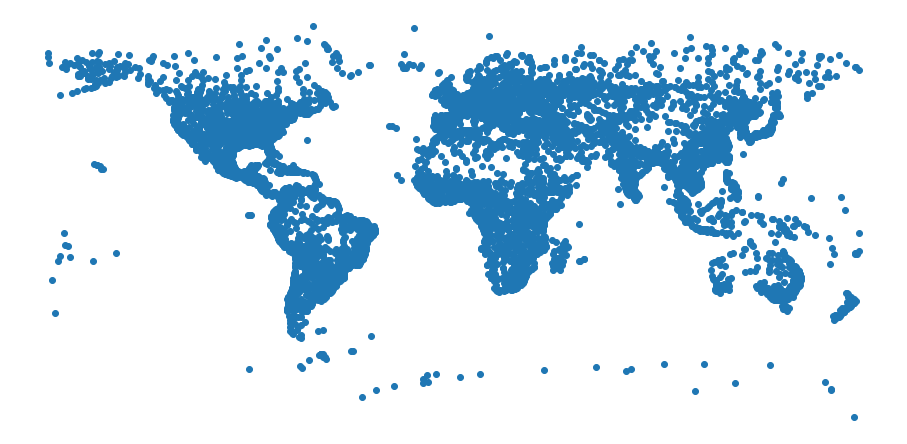

In [5]:
gdf_ne_pop_places_10 = gpd.read_file(url_ne_pop_places_10)
gdf_ne_pop_places_10.plot(figsize=[16,8]).set_axis_off()

Wow, that was easy. Let's move on.

## Day 2: Lines

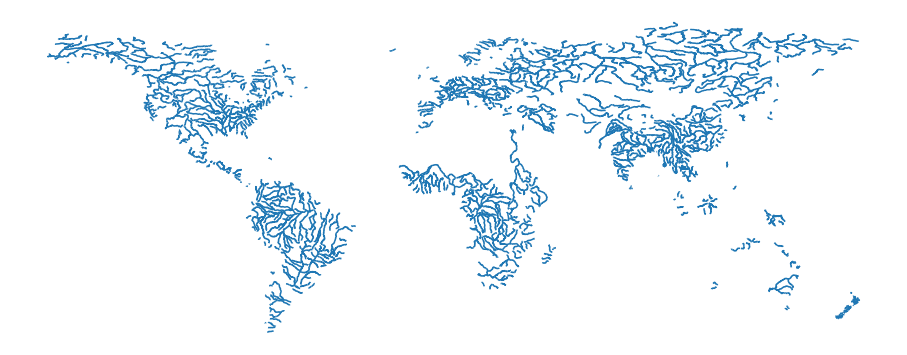

In [6]:
gdf_ne_geo_lines_10 = gpd.read_file(url_ne_geo_lines_10)
gdf_ne_geo_lines_10.plot(figsize=[16,8]).set_axis_off()

Waterways!

## Day 3: Polygons

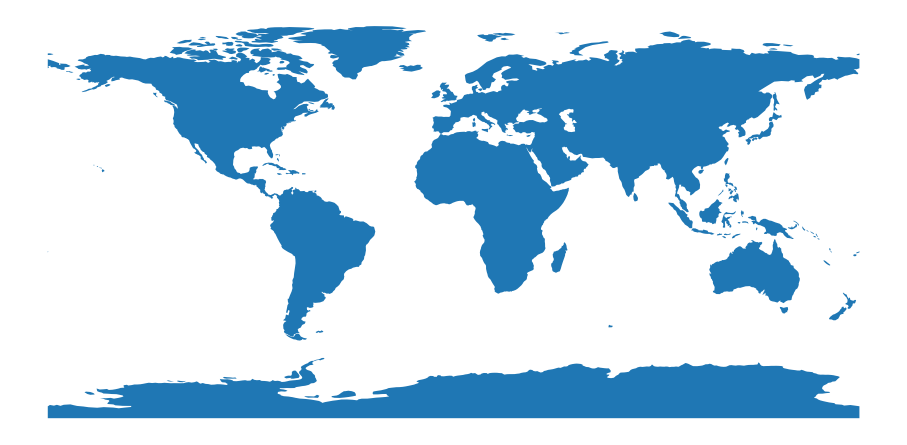

In [7]:
gdf_ne_land_110 = gpd.read_file(url_ne_land_110)
gdf_ne_land_110.plot(figsize=[16,8]).set_axis_off()

Oh hey, that's an actual map of some recognizeable things!

## Day 4: A bad map

Strictly speaking, all the maps so far have been "bad maps" - I'm deliberately going slow and avoiding adornment. But let's try to mess things up deliberately so that I can add something to my "Cursed maps" series.

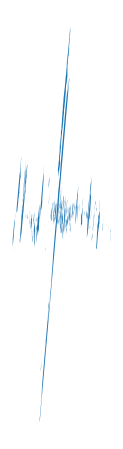

In [8]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gsr_ne_admin_0_110 = GeoSeries(gdf_ne_admin_0_110.geometry)
gsr_ne_admin_0_110.skew(10, 70).rotate(15).plot(figsize=[16,8]).set_axis_off()

Fabulous. Everything is so smooshed up it looks more like an artisanal North arrow.

## Day 5: Analog map

> an·a·log - /ˈanlˌôɡ,ˈanlˌäɡ/
> _adjective_
> relating to or using signals or information represented by a continuously variable physical quantity such as spatial position, voltage, etc.
> _"analog signals"_

So we'll make a line magnitude map

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Text(130.0, 0.5, '')

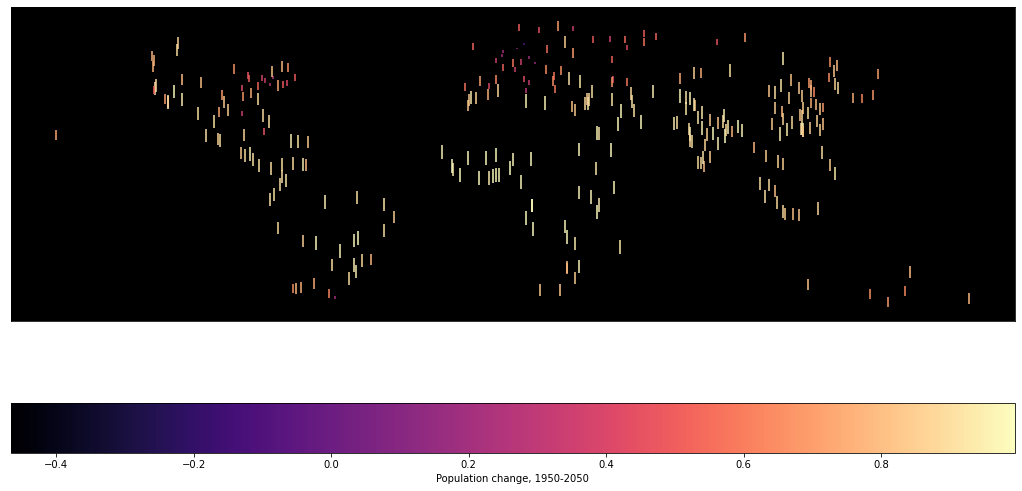

In [19]:
from shapely.geometry import LineString

gdf_ne_pop_places_10 = gpd.read_file(url_ne_pop_places_10)
gdf_ne_pop_places_10_scale2 = gdf_ne_pop_places_10[
    (gdf_ne_pop_places_10['SCALERANK'] <= 3) &
    (gdf_ne_pop_places_10['POP1950'] > 0) &
    (gdf_ne_pop_places_10['POP2050'] > 0)
]

gdf_ne_pop_places_10_scale2['delta'] = ((gdf_ne_pop_places_10_scale2['POP2050'] - gdf_ne_pop_places_10_scale2['POP1950']) / gdf_ne_pop_places_10_scale2['POP2050'])

def create_lines(row):
    # Get the magnitude value
    magnitude = row['delta']
    differential = 5
    
    # Get the point geometry
    point_geometry = row['geometry']
    
    # Calculate the proportional distance based on the magnitude
    # You can adjust the distance factor based on your data and coordinate system
    if magnitude >= 0:
        # For positive magnitudes (North), extend the line upwards
        line_coords = [(point_geometry.x, point_geometry.y), (point_geometry.x, point_geometry.y + differential * magnitude)]
    else:
        # For negative magnitudes (South), extend the line downwards
        line_coords = [(point_geometry.x, point_geometry.y), (point_geometry.x, point_geometry.y - differential * abs(magnitude))]
    
    # Create a LineString geometry from the coordinates
    return LineString(line_coords)

gdf_ne_pop_places_10_scale2['geometry'] = gdf_ne_pop_places_10_scale2.apply(create_lines, axis=1)

ax = gdf_ne_pop_places_10_scale2.plot(
    figsize=(18, 10),
    column="delta",
    cmap = "magma",
    legend=True,
    legend_kwds={"label": "Population change, 1950-2050", "orientation": "horizontal"}
)

ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

You may note that I ran out of time on this one 🤷‍♂️

## Day 6: Asia

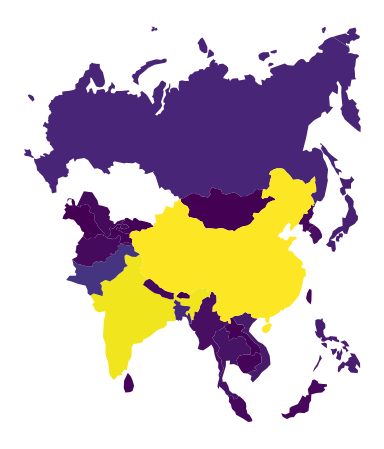

In [10]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gdf_ne_admin_0_110.columns.values
asia_set = ['AFG', 'BGD', 'BTN', 'CH1', 'IND', 'JPN', 'KAZ', 'KGZ', 'KHM', 'KOR', 'LAO', 'LKA', 'MMR', 'MNG', 'MYS', 'NPL', 'PAK', 'PHL', 'PRK', 'RUS', 'THA', 'TJK', 'TKM', 'TWN', 'UZB', 'VNM']

gdf_ne_admin_0_110_asia = gdf_ne_admin_0_110[gdf_ne_admin_0_110['SOV_A3'].isin(asia_set)]

gdf_ne_admin_0_110_asia = gdf_ne_admin_0_110_asia.to_crs("ESRI:102027")

gdf_ne_admin_0_110_asia.plot(
    figsize=[16,8],
    column="POP_EST"
).set_axis_off()

No idea where Kazakhstan went, and no time to find out.

## Day 7: Navigation
Many thanks to Cesar Cheng [for this great 15 minute city example](https://medium.com/@cheng.cesar/15-min-city-8c00dbe279fc) - I've adapted it to focus on Huy, Belgium.

In [11]:
from shapely.geometry import Point, Polygon
import mapclassify
import networkx as nx
import osmnx as ox

In [12]:
place = 'Huy, Belgium'
network_type = 'walk'
trip_times = [5,10,15,25] # in minutes
travel_speed = 4.5 #walking speed in km/hour
Graph = ox.graph_from_address(place,network_type=network_type)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


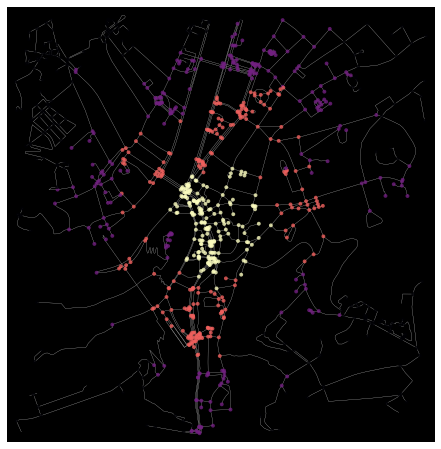

In [13]:
grand_place = (50.518090631766746, 5.2409010386558705)
center_node = ox.get_nearest_node(Graph,grand_place)

meters_per_minute = travel_speed * 1000 / 60 
for u, v, k, data in Graph.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
    
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='magma', start=0, return_hex=True)
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(Graph, center_node, radius=trip_time,  distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in Graph.nodes()]
ns = [15 if node in node_colors else 0 for node in Graph.nodes()]
# plot graph
fig, ax = ox.plot_graph(
    Graph, 
    node_color=nc, 
    node_size=ns, 
    node_alpha=0.8, 
    node_zorder=2,
    bgcolor='k', 
    edge_linewidth=0.2, 
    edge_color='#999999'
)

## Day 8: Africa

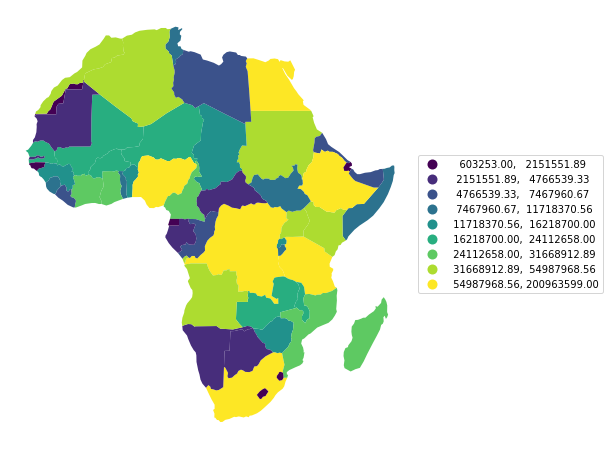

In [14]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gdf_ne_admin_0_110.columns.values
africa_set = ['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COD', 'COG', 'DJI', 'DZA', 'EGY', 'ERI', 'ETH', 'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LBY', 'LSO', 'MAR', 'MDG', 'MLI', 'MOZ', 'MRT', 'MWI', 'NAM', 'NER', 'NGA', 'RWA', 'SAH', 'SDN', 'SDS', 'SEN', 'SLE', 'SOL', 'SOM', 'SWZ', 'TCD', 'TGO', 'TUN', 'TZA', 'UGA', 'ZAF', 'ZMB', 'ZWE']

gdf_ne_admin_0_110_africa = gdf_ne_admin_0_110[gdf_ne_admin_0_110['SOV_A3'].isin(africa_set)]

gdf_ne_admin_0_110_africa = gdf_ne_admin_0_110_africa.to_crs("ESRI:102011")

gdf_ne_admin_0_110_africa.plot(
    figsize=[16,8],
    column="POP_EST",
    scheme="QUANTILES",
    k=9,
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)}
).set_axis_off()

## Day 9: Hexagons

There's [an excellent example of using H3 polygons in GeoPandas](https://stackoverflow.com/a/68137170/1676407) available, and I'll adapt that to show GDP per capita in African countries (those with data - Equatorial Guinea is left out of this one).

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/h3pandas/h3pandas.py:751: UserWarning: 7 rows did not generate a H3 cell.Consider using a finer resolution.
  warnings.warn(


(-21.501382463821862, 55.03914506499815, -38.47912675234812, 41.29023783955406)

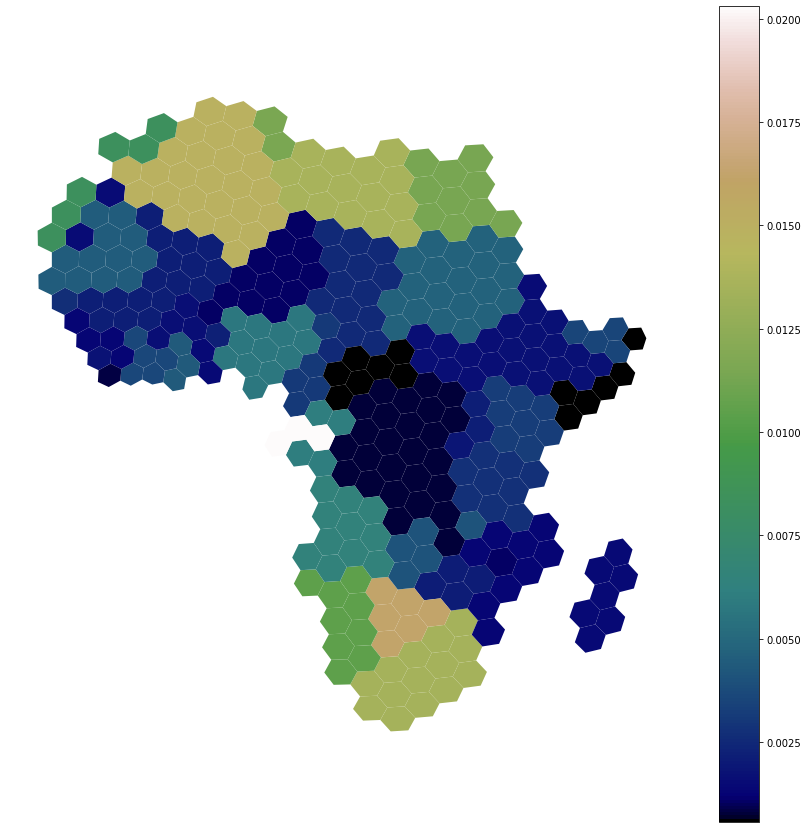

In [15]:
import h3pandas

gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf.loc[gdf['continent'].eq('Africa')]
gdf['gdp_md_per_capita'] = gdf['gdp_md_est'].div(gdf['pop_est'])
resolution = 2

# Resample to H3 cells
gdf_h3 = gdf.h3.polyfill_resample(resolution)
ax = gdf_h3.plot(
    figsize=(15, 15), 
    column='gdp_md_per_capita', 
    legend=True,
    cmap='gist_earth'
)
ax.axis('off')

(Side note - there are [some great cmap options in the matplotlib documentation](https://matplotlib.org/stable/users/explain/colors/colormaps.html) - I dig this `gist_earth` one that's supposed to look like "Earth's colors".)

## Day 10: North America

Since it's just another continent on the list, I'll switch the same example over there.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/h3pandas/h3pandas.py:751: UserWarning: 1 rows did not generate a H3 cell.Consider using a finer resolution.
  warnings.warn(


(-174.88036951435228, -8.725123518932747, 3.18704403937469, 87.74106770088676)

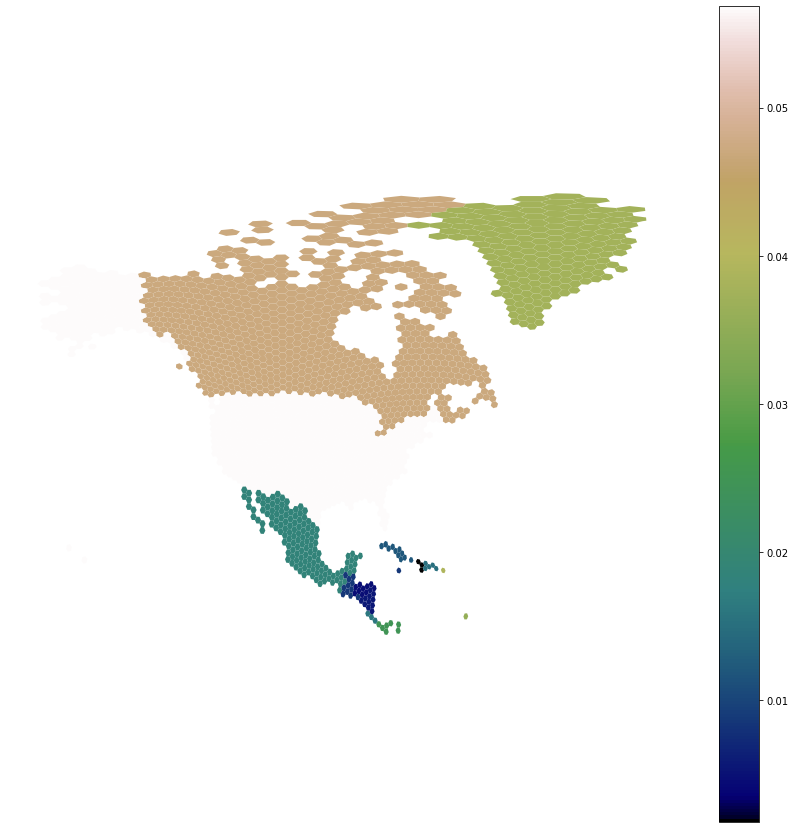

In [16]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf.loc[gdf['continent'].eq('North America')]
gdf['gdp_md_per_capita'] = gdf['gdp_md_est'].div(gdf['pop_est'])
resolution = 3

# Resample to H3 cells
gdf_h3 = gdf.h3.polyfill_resample(resolution)
ax = gdf_h3.plot(
    figsize=(15, 15), 
    column='gdp_md_per_capita', 
    legend=True,
    cmap='gist_earth'
)
ax.axis('off')

OHHHHHHHH GUESS WHO CROSSES THE DATELINE??? __snaps fingers repeatedly__

## Day 11: Retro

Let's turn [Rob Simmon's Blue Marble](https://earthobservatory.nasa.gov/blogs/elegantfigures/2011/10/06/crafting-the-blue-marble/) into [ASCII art.](https://www.educative.io/answers/how-to-generate-ascii-art-from-image-using-python)

In [35]:
import urllib
from PIL import Image,ImageDraw,ImageFont
import math

url = 'https://earthobservatory.nasa.gov/blogs/elegantfigures/wp-content/uploads/sites/4/2011/10/land_shallow_topo_2011_8192.jpg'

urllib.request.urlretrieve(url, "land_shallow_topo_2011_8192.jpg")

ASCII_CHARS = ["@", "#", "$", "%", "?", "*", "+", ";", ":", ",", "."]

def resize(image, new_width = 110):
    old_width, old_height = image.size
    new_height = round(new_width * old_height / old_width)
    return image.resize((new_width, new_height))

def to_greyscale(image):
    return image.convert("L")

def pixel_to_ascii(image):
    pixels = image.getdata()
    ascii_str = "";
    for pixel in pixels:
        ascii_str += ASCII_CHARS[pixel//25];
    return ascii_str

def main():
    image = Image.open("land_shallow_topo_2011_8192.jpg")
    image = resize(image);
    greyscale_image = to_greyscale(image)
    ascii_str = pixel_to_ascii(greyscale_image)
    img_width = greyscale_image.width
    ascii_str_len = len(ascii_str)
    ascii_img=""
    #Split the string based on width  of the image
    for i in range(0, ascii_str_len, img_width):
        ascii_img += ascii_str[i:i+img_width] + "\n"
        
    #ascii_img
    #save the string to a file
    with open("data/ascii_image.txt", "w") as f:
        f.write(ascii_img);
main()

print(open("data/ascii_image.txt", "r").read())

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@###@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@#%%?*+;;+***+*++::,::;+?%$@@@@@@@@@###@@@@@@###$##@@@@@@@@$$@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@##$$#$$%???*:*$?+.............;$@@@@@@@@$?*%$@@@@@@#@@####@@@@@@@$%%%#@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@#$%$$$$???*?*?@@#$$%+........,:*#@@@@@@@@@#@@@@@@@@@@@#%%$$@@@@##$%%%%%%$@@@@@@@#$@@@@@@@@@@@
@@@@@@##@@@@@@@@#$$%%%%#$%%%????%#@@@@?:......;?#@@@@@@@@@@@@@##@@@@@@@$#@@#$$$$$%%%%%%%%$$$$%####$$###@@@@@@@
##@@#$%$$$$$$##$$$$$$$$$#$$$$%$$%?%#@@#*....,+?$@@@@@@@@@@@#$$$$###@#####$$$$$$$$$$$$$$$$$$$$$$$$%$$$$$$$$$$$$
#$#@$$$$$$$$$$$$$##$$$$$$$%$$$@#$%%%@@#*..:%#@@@#%#@@@@@@@#$$#########$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$%%%%
@@@@$$$$%%%%%$$$$$$###$$$$#@@###$##@@@@$;:$@@@@@@#@@@@@@#$$#########################$$$$$$$$$$$$$$$$$$$$$$$$##
@

## Day 12: South America

## Day 13: Choropleth

## Day 14: Europe

## Scratchpad

In [17]:
import geopandas
import geodatasets
import contextily as cx

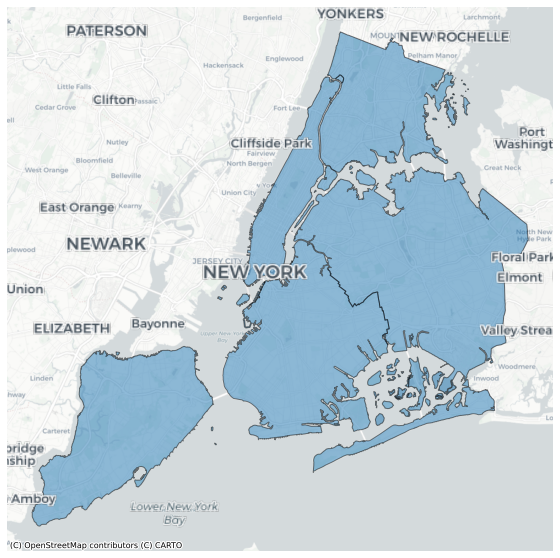

In [18]:
df = geopandas.read_file(geodatasets.get_path("nybb"))
df_wm = df.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, zoom=10)
ax.set_axis_off()